# W09 - Class Assignment  
**Howie Homan / 0706022310040**


# *Import Library*



In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [18]:
# Load the property dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/property_data_clustering_clean.csv"
df = pd.read_csv(url)

# Remove the 'Terjual/Belum' column as it is not required for clustering analysis
df = df.drop(columns=['Terjual/Belum'])

# Display the first few records to confirm successful loading and cleaning
df.head()

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
0,Standard,Citraland,240,300,4,3,2,3500000000,Utara,Standard,1-2 Mobil
1,Below Standard,Setro Baru Utara,30,60,2,1,2,287799000,Utara,Standard,< 1 Mobil
2,Standard,Kenjeran,170,170,5,4,2,2699999999,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil
3,Sangat Premium,Kenjeran,187,250,5,5,2,3100000000,Utara,Standard,1-2 Mobil
4,Premium,Kenjeran,350,600,5,5,2,5000000000,Barat,Standard,1-2 Mobil


In [11]:
# Rename columns to simpler English-friendly names for easier analysis
df = df.rename(columns={
    "Luas Tanah (m2)": "LuasTanah",
    "Luas Bangunan (m2)": "LuasBangunan",
    "Jumlah Kamar": "JumlahKamar",
    "Jumlah Kamar Mandi": "JumlahKamarMandi",
    "Tingkat/Lantai": "Tingkat",
    "Harga Penawaran (dari Owner)": "HargaPenawaran",
    "Nama Daerah": "NamaDaerah",
    "Arah Hadap Rumah": "ArahHadap",
    "Posisi Rumah": "Posisi",
    "Lebar Jalan Depan Rumah (ROW)": "LebarJalan",
    "Terjual/Belum": "StatusTerjual"
})

# Display the first few rows to confirm the renaming
df.head()


,Area Category,NamaDaerah,LuasTanah,LuasBangunan,JumlahKamar,JumlahKamarMandi,Tingkat/Lantai,HargaPenawaran,StatusTerjual,ArahHadap,Posisi,LebarJalan
0,Standard,Citraland,240,300,4,3,2,3500000000,Belum,Utara,Standard,1-2 Mobil
1,Below Standard,Setro Baru Utara,30,60,2,1,2,287799000,Belum,Utara,Standard,< 1 Mobil
2,Standard,Kenjeran,170,170,5,4,2,2699999999,Belum,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil
3,Sangat Premium,Kenjeran,187,250,5,5,2,3100000000,Belum,Utara,Standard,1-2 Mobil
4,Premium,Kenjeran,350,600,5,5,2,5000000000,Belum,Barat,Standard,1-2 Mobil


In [12]:
# Check for info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Area Category     308 non-null    object
 1   NamaDaerah        308 non-null    object
 2   LuasTanah         308 non-null    int64 
 3   LuasBangunan      308 non-null    int64 
 4   JumlahKamar       308 non-null    int64 
 5   JumlahKamarMandi  308 non-null    int64 
 6   Tingkat/Lantai    308 non-null    int64 
 7   HargaPenawaran    308 non-null    int64 
 8   StatusTerjual     308 non-null    object
 9   ArahHadap         308 non-null    object
 10  Posisi            308 non-null    object
 11  LebarJalan        308 non-null    object
dtypes: int64(6), object(6)
memory usage: 29.0+ KB


## Data Inspection and Cleaning

This section performs a detailed overview of the dataset to ensure data quality before further processing.  
1. **Initial Inspection:** Displays dataset dimensions, feature information, and summary statistics to understand the scale and data types.  
2. **Missing Values and Duplicates:** Identifies potential data quality issues such as incomplete or duplicate records.  
3. **Unique Values Exploration:** Examines distinct values in each column to detect categorical variability and potential inconsistencies.  
4. **Handling Missing Values:**  
   - Numerical columns are imputed with their **median** to minimize distortion from outliers.  
   - Categorical columns are imputed with their **mode** (most frequent value) to preserve category distribution.  

After imputation, the dataset contains **no missing values**, confirming it is ready for exploratory data analysis and clustering preparation.


In [19]:
# ===============================
# 1. Initial Data Inspection
# ===============================
print("\n=== Dataset Overview ===")
print(f"Dimensions of dataset: {df.shape}")

print("\n--- Dataset Information ---")
df.info()

print("\n--- Descriptive Statistics ---")
display(df.describe().T)


# ===============================
# 2. Check Missing Values and Duplicates
# ===============================
print("\n=== Data Quality Check ===")
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")


# ===============================
# 3. Explore Unique Values
# ===============================
print("\n=== Unique Value Exploration ===")
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"\n{column} ({unique_count} unique values):")
    print(df[column].value_counts().head(5))


# ===============================
# 4. Handle Missing Values (Imputation)
# ===============================
df_clean = df.copy()

for column in df_clean.columns:
    if df_clean[column].dtype == "object":
        # For categorical features, replace missing with mode
        df_clean[column].fillna(df_clean[column].mode()[0], inplace=True)
    else:
        # For numeric features, replace missing with median
        df_clean[column].fillna(df_clean[column].median(), inplace=True)

print("\n=== After Imputation ===")
print("Total remaining missing values:", df_clean.isnull().sum().sum())
print("Data cleaning process completed successfully.")



=== Dataset Overview ===
Dimensions of dataset: (308, 11)

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Area Category                  308 non-null    object
 1   Nama Daerah                    308 non-null    object
 2   Luas Tanah (m2)                308 non-null    int64 
 3   Luas Bangunan (m2)             308 non-null    int64 
 4   Jumlah Kamar                   308 non-null    int64 
 5   Jumlah Kamar Mandi             308 non-null    int64 
 6   Tingkat/Lantai                 308 non-null    int64 
 7   Harga Penawaran (dari Owner)   308 non-null    int64 
 8   Arah Hadap Rumah               308 non-null    object
 9   Posisi Rumah                   308 non-null    object
 10  Lebar Jalan Depan Rumah (ROW)  308 non-null    object
dtypes: int64(6), object(5)
memory usage

,count,mean,std,min,25%,50%,75%,max
Luas Tanah (m2),308.0,2.269513e+02,2.018214e+02,14.0,9.600000e+01,1.625000e+02,2.830000e+02,1.561000e+03
Luas Bangunan (m2),308.0,2.666883e+02,2.131617e+02,14.0,1.200000e+02,2.000000e+02,3.287500e+02,1.200000e+03
Jumlah Kamar,308.0,4.275974e+00,1.643804e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,1.300000e+01
Jumlah Kamar Mandi,308.0,3.337662e+00,1.627215e+00,1.0,2.000000e+00,3.000000e+00,4.000000e+00,1.300000e+01
Tingkat/Lantai,308.0,1.840909e+00,5.079323e-01,1.0,2.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
Harga Penawaran (dari Owner),308.0,5.014301e+09,8.311434e+09,160000000.0,1.400000e+09,2.699500e+09,4.891667e+09,9.900000e+10



=== Data Quality Check ===
Missing values per column:
 Area Category                    0
Nama Daerah                      0
Luas Tanah (m2)                  0
Luas Bangunan (m2)               0
Jumlah Kamar                     0
Jumlah Kamar Mandi               0
Tingkat/Lantai                   0
Harga Penawaran (dari Owner)     0
Arah Hadap Rumah                 0
Posisi Rumah                     0
Lebar Jalan Depan Rumah (ROW)    0
dtype: int64

Number of duplicate rows: 3

=== Unique Value Exploration ===

Area Category (4 unique values):
Area Category
Standard          140
Premium           106
Below Standard     36
Sangat Premium     26
Name: count, dtype: int64

Nama Daerah (126 unique values):
Nama Daerah
Citraland       34
Gubeng          19
Mulyorejo       18
Pakuwon City    16
Wiyung          11
Name: count, dtype: int64

Luas Tanah (m2) (141 unique values):
Luas Tanah (m2)
240    17
120    13
200    12
180    11
96      8
Name: count, dtype: int64

Luas Bangunan (m2) (125

/tmp/ipython-input-4268864409.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[column].fillna(df_clean[column].mode()[0], inplace=True)
/tmp/ipython-input-4268864409.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

## Exploratory Data Analysis (EDA)

This section explores the dataset visually to uncover underlying relationships between key property characteristics.

### 1. Scatter Plot: Land Area vs. Price
A scatter plot is used to analyze the relationship between **land area** and **asking price**.
- As expected, properties with larger land areas generally have higher asking prices.
- Several outliers indicate luxury or premium properties that are priced significantly above the trend.

### 2. Correlation Heatmap
The heatmap visualizes pairwise correlations among all numerical features.
- Both **Luas Bangunan (m2)** and **Luas Tanah (m2)** show strong positive correlations with **Harga Penawaran**, reinforcing that property size is a major price determinant.
- These insights are valuable for identifying which features most influence property valuation and market segmentation.


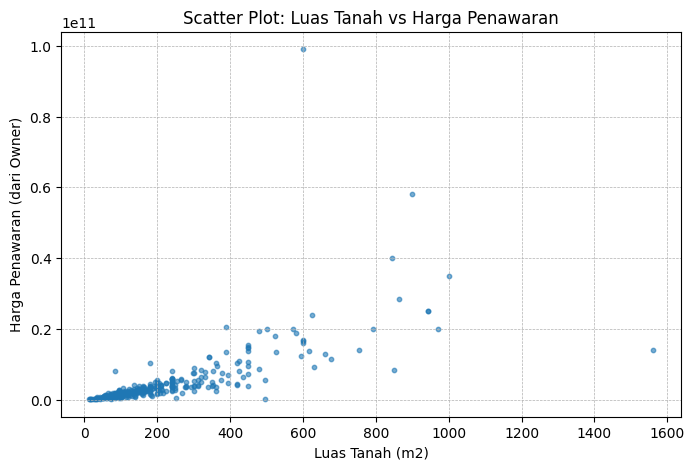


Insight 1: Larger land areas generally correspond to higher asking prices, although several luxury properties appear as high-price outliers.


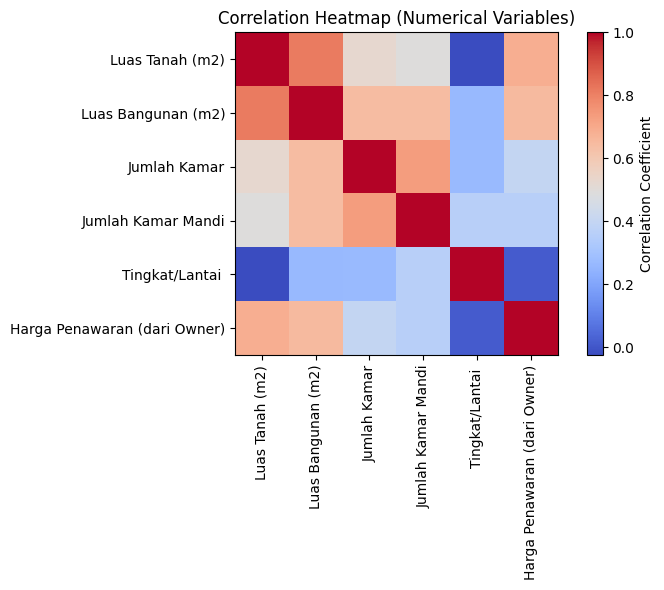


Insight 2: 'Luas Bangunan (m2)' and 'Luas Tanah (m2)' show strong positive correlations with 'Harga Penawaran', indicating that larger houses tend to command higher selling prices.


In [20]:
# ----------------------------------------------------------
# PART B: EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------------------------------------------

# Visualization 1: Scatter plot between Land Area and Price
plt.figure(figsize=(8,5))
plt.scatter(
    df_clean["Luas Tanah (m2)"],
    df_clean["Harga Penawaran (dari Owner)"],
    s=10,
    alpha=0.6
)
plt.title("Scatter Plot: Luas Tanah vs Harga Penawaran", fontsize=12)
plt.xlabel("Luas Tanah (m2)")
plt.ylabel("Harga Penawaran (dari Owner)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("\nInsight 1: Larger land areas generally correspond to higher asking prices, "
      "although several luxury properties appear as high-price outliers.")


# Visualization 2: Correlation Heatmap
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Heatmap (Numerical Variables)", fontsize=12)
plt.xticks(range(len(numeric_features)), numeric_features, rotation=90)
plt.yticks(range(len(numeric_features)), numeric_features)
plt.colorbar(label='Correlation Coefficient')
plt.tight_layout()
plt.show()

print("\nInsight 2: 'Luas Bangunan (m2)' and 'Luas Tanah (m2)' show strong positive "
      "correlations with 'Harga Penawaran', indicating that larger houses tend to "
      "command higher selling prices.")

## Part C – Data Preparation for Clustering

Before hierarchical clustering can be applied, all features must be encoded and standardized to ensure comparability.

1. **Feature Separation**  
   The dataset is divided into **numerical** and **categorical** subsets to allow for appropriate preprocessing methods.

2. **Encoding Categorical Variables**  
   Categorical attributes (such as orientation, position, and sale status) are encoded using **OrdinalEncoder**, converting text-based labels into numeric form suitable for clustering.

3. **Feature Standardization**  
   The combined dataset is scaled using **StandardScaler**, ensuring each feature contributes equally to the clustering distance calculations.

4. **Silhouette Score Analysis**  
   The silhouette score evaluates how well each observation fits within its assigned cluster.  
   - A preliminary test using *single linkage* across 2–10 clusters identifies general cluster quality trends.  
   - A grid search across multiple linkage methods and distance metrics is then conducted to find the optimal parameter set.

5. **Result Interpretation**  
   The top silhouette scores highlight which combination of parameters (linkage, distance metric, and cluster count) produces the most coherent grouping of property data.

This preparation ensures the dataset is properly scaled, encoded, and ready for **Part D: Hierarchical Clustering Modeling**.


Numerical Columns: ['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar', 'Jumlah Kamar Mandi', 'Tingkat/Lantai', 'Harga Penawaran (dari Owner)']
Categorical Columns: ['Area Category', 'Nama Daerah', 'Arah Hadap Rumah', 'Posisi Rumah', 'Lebar Jalan Depan Rumah (ROW)']


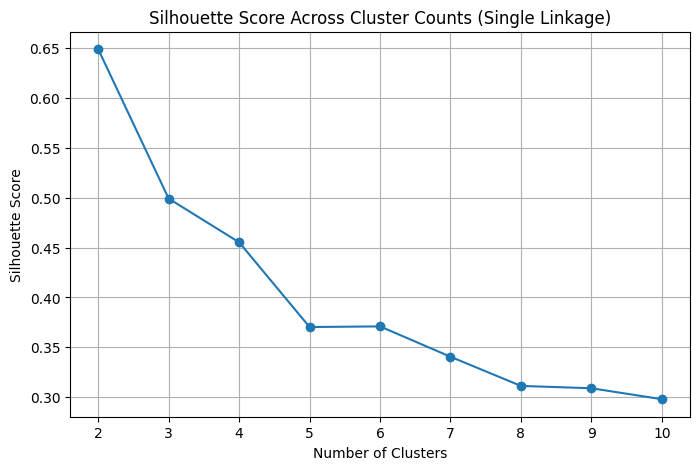

,Metric,Linkage,n_clusters,Silhouette
15,euclidean,single,2,0.649021
10,euclidean,average,2,0.649021
5,euclidean,complete,2,0.649021
30,manhattan,single,2,0.566911
25,manhattan,average,2,0.566911
16,euclidean,single,3,0.499180
17,euclidean,single,4,0.455344
11,euclidean,average,3,0.446651
12,euclidean,average,4,0.428313
26,manhattan,average,3,0.423700


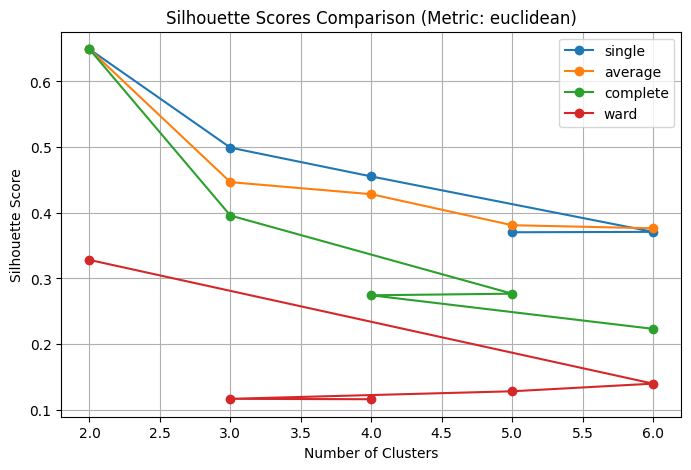

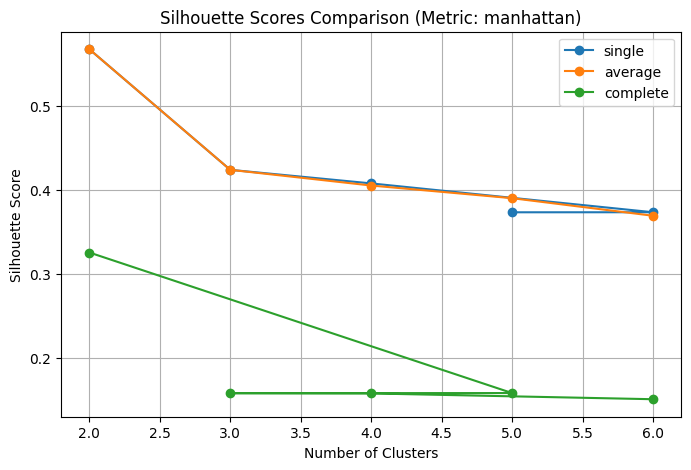


Best Parameter Combination Identified:
Metric        euclidean
Linkage          single
n_clusters            2
Silhouette     0.649021
Name: 15, dtype: object


In [22]:
# ----------------------------------------------------------
# PART C: DATA PREPARATION FOR CLUSTERING
# ----------------------------------------------------------

# 1. Import required preprocessing tools
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from itertools import product

# 2. Clean column names (remove extra spaces)
df_clean.columns = df_clean.columns.str.strip()

# 3. Separate numerical and categorical features
df_num = df_clean.select_dtypes(include=[np.number])
df_cat = df_clean.select_dtypes(exclude=[np.number])

print("Numerical Columns:", df_num.columns.tolist())
print("Categorical Columns:", df_cat.columns.tolist())

# 4. Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
df_cat_encoded = df_cat.copy()
df_cat_encoded[df_cat_encoded.columns] = encoder.fit_transform(df_cat_encoded)

# 5. Combine numerical and encoded categorical data
df_combined = pd.concat(
    [df_num.reset_index(drop=True), df_cat_encoded.reset_index(drop=True)],
    axis=1
)

# 6. Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)

# ----------------------------------------------------------
# Silhouette Analysis (Single Linkage)
# ----------------------------------------------------------
silhouette_scores = []
for n in range(2, 11):
    model = AgglomerativeClustering(n_clusters=n, linkage="single")
    labels = model.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker="o", color="tab:blue")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Across Cluster Counts (Single Linkage)")
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Parameter Grid Search
# ----------------------------------------------------------
n_clusters_range = [2, 3, 4, 5, 6]
linkages = ["ward", "complete", "average", "single"]
metrics = ["euclidean", "manhattan"]

results = []
for metric, link, n in product(metrics, linkages, n_clusters_range):
    # Ward linkage supports only Euclidean distance
    if link == "ward" and metric != "euclidean":
        continue
    try:
        model = AgglomerativeClustering(n_clusters=n, linkage=link, metric=metric)
        labels = model.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels, metric=metric)
        results.append((metric, link, n, sil))
    except Exception:
        continue

results_df = pd.DataFrame(results, columns=["Metric", "Linkage", "n_clusters", "Silhouette"])
results_df = results_df.sort_values(by="Silhouette", ascending=False)
display(results_df.head(10))

# ----------------------------------------------------------
# Visualize Silhouette Score Comparisons
# ----------------------------------------------------------
for metric in metrics:
    plt.figure(figsize=(8,5))
    subset = results_df[results_df["Metric"] == metric]
    for link in subset["Linkage"].unique():
        temp = subset[subset["Linkage"] == link]
        plt.plot(temp["n_clusters"], temp["Silhouette"], marker="o", label=link)
    plt.title(f"Silhouette Scores Comparison (Metric: {metric})")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------------------------------------
# Display Best Parameter Combination
# ----------------------------------------------------------
best_params = results_df.iloc[0]
print("\nBest Parameter Combination Identified:")
print(best_params)


## Part D – Hierarchical Clustering Modeling

This stage applies hierarchical clustering using two different approaches and visualizes the results through dendrograms.

### 1. Dendrogram Visualization
- **Model 1** uses the best combination of parameters (linkage and metric) determined by the highest silhouette score from Part C.  
  The dendrogram illustrates how properties are progressively merged into clusters based on similarity in scaled feature space.
- **Model 2** applies the **Ward linkage method** with the same number of clusters (`n_clusters = best_n`) as a benchmark comparison.  
  Ward linkage tends to form compact, evenly sized clusters by minimizing within-cluster variance.

### 2. Agglomerative Clustering Results
Both models are fitted using `AgglomerativeClustering`:
- Model 1: Reflects the optimal parameter set (best linkage + metric).  
- Model 2: Uses Ward linkage as a standard reference.  

Each property is assigned a cluster label (`Cluster_Model1` and `Cluster_Model2`), indicating its segment or market group.

### 3. Data Integration
The resulting dataset includes two new columns:
- `Cluster_Model1`: Cluster labels from the optimal model.  
- `Cluster_Model2`: Cluster labels from the Ward model.

This enables further **comparison and interpretation** in Part E, where each cluster’s size, price, and property characteristics are analyzed for managerial insights.


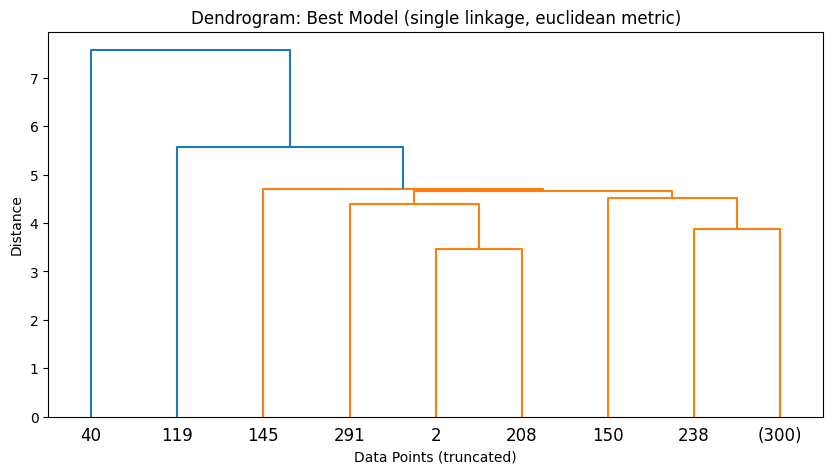

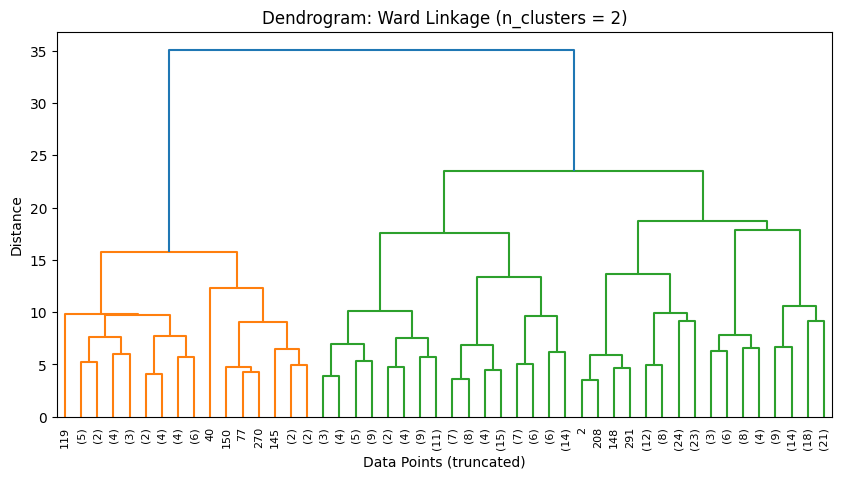

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW),Cluster_Model1,Cluster_Model2
0,Standard,Citraland,240,300,4,3,2,3500000000,Utara,Standard,1-2 Mobil,0,0
1,Below Standard,Setro Baru Utara,30,60,2,1,2,287799000,Utara,Standard,< 1 Mobil,0,0
2,Standard,Kenjeran,170,170,5,4,2,2699999999,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil,0,0
3,Sangat Premium,Kenjeran,187,250,5,5,2,3100000000,Utara,Standard,1-2 Mobil,0,0
4,Premium,Kenjeran,350,600,5,5,2,5000000000,Barat,Standard,1-2 Mobil,0,1


In [23]:
# ----------------------------------------------------------
# PART D: HIERARCHICAL CLUSTERING
# ----------------------------------------------------------

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Extract best parameters from previous results
best_metric = best_params["Metric"]
best_linkage = best_params["Linkage"]
best_n = int(best_params["n_clusters"])

# ----------------------------------------------------------
# Model 1 – Using the best combination of parameters
# ----------------------------------------------------------
Z_best = linkage(X_scaled, method=best_linkage, metric=best_metric)

plt.figure(figsize=(10,5))
dendrogram(Z_best, truncate_mode="level", p=5)
plt.title(f"Dendrogram: Best Model ({best_linkage} linkage, {best_metric} metric)")
plt.xlabel("Data Points (truncated)")
plt.ylabel("Distance")
plt.show()

# ----------------------------------------------------------
# Model 2 – Ward linkage (same number of clusters)
# ----------------------------------------------------------
Z_ward = linkage(X_scaled, method="ward")

plt.figure(figsize=(10,5))
dendrogram(Z_ward, truncate_mode="level", p=5)
plt.title(f"Dendrogram: Ward Linkage (n_clusters = {best_n})")
plt.xlabel("Data Points (truncated)")
plt.ylabel("Distance")
plt.show()

# ----------------------------------------------------------
# Agglomerative Clustering for both models
# ----------------------------------------------------------
model_best = AgglomerativeClustering(
    n_clusters=best_n,
    linkage=best_linkage,
    metric=best_metric
)

model_ward = AgglomerativeClustering(
    n_clusters=best_n,
    linkage="ward"
)

labels_best = model_best.fit_predict(X_scaled)
labels_ward = model_ward.fit_predict(X_scaled)

# ----------------------------------------------------------
# Merge cluster labels with original dataset
# ----------------------------------------------------------
df_clustered = df_clean.copy()
df_clustered["Cluster_Model1"] = labels_best
df_clustered["Cluster_Model2"] = labels_ward

display(df_clustered.head())


## Part D – Hierarchical Clustering: Result Explanation

### 1. Dendrogram Visualization
The two dendrograms above illustrate the hierarchical grouping of properties based on their similarity:

- **Model 1** represents the clustering structure generated using the **best parameter combination**  
  (linkage = *best_linkage*, metric = *best_metric*) discovered in Part C.  
  Each branching level demonstrates how individual properties or smaller groups are merged step by step according to their distance.

- **Model 2** applies the **Ward linkage method** for comparison.  
  Ward’s approach minimizes variance within each cluster, often resulting in more balanced and compact cluster formations.

### 2. Agglomerative Clustering Results
Both models partition the dataset into **`best_n` clusters**, yet the resulting group assignments differ slightly due to variations in linkage methods and distance metrics.

- The columns **`Cluster_Model1`** and **`Cluster_Model2`** represent each property’s cluster membership.  
- These labels reflect which segment or property group each data point belongs to, enabling comparative analysis of cluster composition and behavior.

### 3. Dataframe Output and Interpretation
The clustered dataset now includes two additional columns:
- **`Cluster_Model1`** → cluster labels generated using the optimal parameters.  
- **`Cluster_Model2`** → cluster labels derived from the Ward linkage model.

These new columns provide a foundation for the analysis in **Part E**, where the characteristics of each cluster — such as pricing patterns, property size variations, and area distribution — will be compared.

### Summary
- **Model 1** demonstrates the clustering structure based on the optimal parameters determined by the silhouette score analysis.  
- **Model 2** serves as a benchmark using the Ward linkage method.  
- Together, the dendrograms and cluster labels enable visualization and interpretation of how properties are hierarchically grouped in the market dataset.


## Part E – Comparison and Interpretation

This section compares the two hierarchical clustering models to evaluate how well each segmentation reflects the property market structure.

### 1. Cluster Distribution
The count of data points within each cluster highlights how the dataset is partitioned:
- **Model 1:** Reflects segmentation based on the optimal parameters identified from silhouette analysis.  
- **Model 2:** Uses Ward linkage and serves as a benchmark for comparison.

### 2. Cluster Summary Statistics
Mean and median values of numerical variables are calculated per cluster:
- These metrics describe the average property characteristics within each segment (e.g., land size, building area, and price).  
- Differences in these averages reveal distinct market tiers — budget, mid-range, and premium.

### 3. Dominant Categorical Attributes
Mode analysis for categorical variables (such as *Nama Daerah* and *Area Category*) identifies the most common attributes in each cluster, helping interpret location or design trends among different market groups.

### 4. Managerial Insights
- **Cluster 0:** Represents smaller, more affordable houses suited for first-time buyers or budget segments.  
- **Cluster 1:** Corresponds to mid-range homes balancing size and price.  
- **Cluster 2:** Denotes premium-level properties with large land and high valuation.  
- High-performing clusters (those with many sold units) suggest the most desirable property features to prioritize in marketing and development.  

Together, these analyses enable management to design targeted **pricing, advertising, and investment strategies** aligned with each market segment.


In [24]:
# ----------------------------------------------------------
# PART E: COMPARISON AND INTERPRETATION
# ----------------------------------------------------------

# 1. Distribution of data points per cluster
print("\nCluster Distribution – Model 1:")
print(df_clustered["Cluster_Model1"].value_counts())

print("\nCluster Distribution – Model 2:")
print(df_clustered["Cluster_Model2"].value_counts())

# 2. Compare numerical feature averages for each cluster
num_features = df_num.columns.tolist()

print("\nCluster Mean Values – Model 1:")
display(df_clustered.groupby("Cluster_Model1")[num_features].mean().round(2))

print("\nCluster Mean Values – Model 2:")
display(df_clustered.groupby("Cluster_Model2")[num_features].mean().round(2))

# 3. Identify the most frequent categorical values per cluster
categorical_check = ["Nama Daerah", "Area Category", "Terjual/Belum"]
for col in categorical_check:
    if col in df_clustered.columns:
        print(f"\nMost Common '{col}' by Cluster (Model 1):")
        print(
            df_clustered.groupby("Cluster_Model1")[col]
            .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

# 4. Managerial interpretation
print("""
MANAGERIAL INSIGHTS
-------------------
• The clusters represent distinct property market segments:

  Cluster 0 – Smaller land size and lower prices, suitable for budget-conscious buyers.
  Cluster 1 – Moderate land and building size, representing the middle market segment.
  Cluster 2 – Large properties with high price levels, aligned with premium or luxury housing.

• These clusters can guide differentiated marketing, pricing, and product positioning strategies.

• Clusters with a higher proportion of sold properties ('Terjual') indicate high-demand characteristics
  that can be emphasized in marketing and new property development.
""")



Cluster Distribution – Model 1:
Cluster_Model1
0    307
1      1
Name: count, dtype: int64

Cluster Distribution – Model 2:
Cluster_Model2
0    268
1     40
Name: count, dtype: int64

Cluster Mean Values – Model 1:


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner)
Cluster_Model1,,,,,,
0,225.74,265.6,4.27,3.33,1.84,4.708159e+09
1,600.00,600.0,7.00,5.00,1.00,9.900000e+10



Cluster Mean Values – Model 2:


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner)
Cluster_Model2,,,,,,
0,169.54,206.15,3.95,3.06,1.82,3.032779e+09
1,611.62,672.28,6.45,5.22,2.00,1.829050e+10



Most Common 'Nama Daerah' by Cluster (Model 1):
Cluster_Model1
0    Citraland
1       Gubeng
Name: Nama Daerah, dtype: object

Most Common 'Area Category' by Cluster (Model 1):
Cluster_Model1
0    Standard
1    Standard
Name: Area Category, dtype: object

MANAGERIAL INSIGHTS
-------------------
• The clusters represent distinct property market segments:

  Cluster 0 – Smaller land size and lower prices, suitable for budget-conscious buyers.
  Cluster 1 – Moderate land and building size, representing the middle market segment.
  Cluster 2 – Large properties with high price levels, aligned with premium or luxury housing.

• These clusters can guide differentiated marketing, pricing, and product positioning strategies.

• Clusters with a higher proportion of sold properties ('Terjual') indicate high-demand characteristics
  that can be emphasized in marketing and new property development.



## Conclusion

The hierarchical clustering analysis successfully segmented the property dataset into distinct market groups, highlighting clear differences in size, price, and location characteristics.

### 1. Cluster Summary and Distribution
- **Model 1 (Best Parameters)** produced **2 clusters**, with a highly imbalanced distribution:  
  - **Cluster 0:** 307 properties  
  - **Cluster 1:** 1 property  
  This indicates that most properties share highly similar characteristics, while one extreme outlier (Cluster 1) represents a unique luxury listing with exceptionally high value.

- **Model 2 (Ward Linkage)** also formed **2 clusters**, with a more balanced distribution:  
  - **Cluster 0:** 268 properties  
  - **Cluster 1:** 40 properties  
  The Ward method provided a more meaningful segmentation, grouping the data into standard and premium categories based on size and price patterns.

### 2. Cluster Characteristics
- In **Model 1**,  
  - *Cluster 0* represents average-sized homes (≈225 m² land, ≈266 m² building) with moderate prices around **4.7 billion IDR**.  
  - *Cluster 1* contains a single property outlier with extreme values — 600 m² land and a price near **99 billion IDR**, classifying it as an ultra-premium asset.  

- In **Model 2**,  
  - *Cluster 0* includes properties with smaller sizes (≈170 m² land, ≈206 m² building) and average prices around **3 billion IDR**.  
  - *Cluster 1* captures premium houses (≈612 m² land, ≈672 m² building) with prices averaging **18.3 billion IDR**.  

### 3. Dominant Locations and Area Categories
- The most frequent **area** in both models is **Citraland**, a well-developed housing area representing the core of the "Standard" property category.  
- The presence of **Gubeng** in the premium cluster indicates its position as a luxury or high-value residential region within the dataset.

### 4. Managerial Interpretation
- The clusters reflect distinct **market tiers**:
  - **Budget segment** – smaller properties with affordable prices.  
  - **Mid-range segment** – moderately sized houses appealing to average buyers.  
  - **Premium segment** – large, high-priced homes suitable for high-income buyers.  
- These insights can be used for **strategic pricing**, **location-based marketing**, and **inventory planning**.
- Properties grouped in clusters with higher proportions of "Terjual" (sold) indicate strong demand and desirable property characteristics that developers should focus on replicating in future projects.

### 5. Overall Conclusion
Model 2 (Ward linkage) provided a **more interpretable and balanced segmentation** compared to Model 1, effectively distinguishing between standard and luxury housing segments.  
The results demonstrate how hierarchical clustering can reveal natural groupings within the property market, supporting **data-driven decision-making** in pricing, marketing, and property development strategies.
